[View in Colaboratory](https://colab.research.google.com/github/stikbuf/Language_Modeling/blob/master/Keras_Character_Aware_Neural_Language_Models.ipynb)

## Configure the cloud environment


### Mount Google Drive

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

In [2]:
# If you got a "Transport endpoint is not connected." error. Please run this line first to unmount the drive.
# See https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
!fusermount -u drive

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
a = !ls drive/
print('Files in Drive:', a)
assert a!=[], 'Drive should not be empty!'

Files in Drive: ['share_with_me']


In [3]:
local_path='./drive/share_with_me/AI/Character-aware_LM/'
#local_path='./'
import sys
sys.path.append(local_path)
!ls './drive/share_with_me/AI/Character-aware_LM/'

Character-Aware Neural Language Models.ipynb
data
data_loader.py
Keras - Character-Aware Neural Language Models.ipynb
__pycache__
reader.py


In [4]:
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "GPU not avaliable!"
tf.test.gpu_device_name()

'/device:GPU:0'

## Load data

In [1]:
local_path='./'

In [2]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from reader import ptb_raw_data, ptb_producer # by Google

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data(local_path + 'data')
id_to_word = dict((v, k) for k, v in word_to_id.items())
voc_size = len(id_to_word)
voc_size

10000

In [4]:
id_to_word[voc_size]='<START>'
id_to_word[voc_size+1]='<END>'
word_to_id = dict((v, k) for k, v in id_to_word.items())
voc_size = len(id_to_word)
voc_size

10002

In [5]:
word_id = pd.DataFrame.from_dict(word_to_id, orient='index').sort_values(by=0, ascending=True)
word_id.columns = ['id']
print(word_id.head())
print(word_id.tail())

       id
the     0
<unk>   1
<eos>   2
N       3
of      4
              id
ssangyong   9997
swapo       9998
wachter     9999
<START>    10000
<END>      10001


In [6]:
id_word = pd.DataFrame.from_dict(id_to_word, orient='index')
id_word.columns = ['word']
print(id_word.head())
print(id_word.tail())

    word
0    the
1  <unk>
2  <eos>
3      N
4     of
            word
9997   ssangyong
9998       swapo
9999     wachter
10000    <START>
10001      <END>


In [7]:
' '.join([id_to_word[id] for id in train_data[:30]])

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old'

## RNN baseline

In [8]:
import random
seq_len = 35

from tensorflow.python.keras.utils import to_categorical # 源码值得一读

def gen_word_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<START>']] + data[i:i+seq_len] + [word_to_id['<END>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            #print(X.shape)
            cnt += batch_size
            yield X, Y

In [9]:
t = np.array([[1,0,1],[0,1,0]], dtype=int)
to_categorical(t, num_classes=2)

array([[[0., 1.],
        [1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.],
        [1., 0.]]])

In [10]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Dense, Embedding, InputLayer
from tensorflow.python.keras.optimizers import RMSprop

In [11]:
model = Sequential()

embedding_size = 8


model.add(Embedding(input_dim=voc_size,
                    output_dim=embedding_size,
                    input_length=seq_len+1,
                    name='inputEmbedding'))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4, return_sequences=True))
model.add(Dense(voc_size, activation='softmax'))

In [12]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [13]:
optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[ACC, PPL])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputEmbedding (Embedding)   (None, 36, 8)             80016     
_________________________________________________________________
gru_1 (GRU)                  (None, 36, 8)             408       
_________________________________________________________________
gru_2 (GRU)                  (None, 36, 4)             156       
_________________________________________________________________
dense_1 (Dense)              (None, 36, 10002)         50010     
Total params: 130,590
Trainable params: 130,590
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = model.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=100,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/100
50/50 [==============================] - 30s 602ms/step - loss: 9.0434 - ACC: 0.0039 - PPL: 8504.0292 - val_loss: 8.8692 - val_ACC: 0.0058 - val_PPL: 7109.7010
Epoch 2/100
50/50 [==============================] - 26s 521ms/step - loss: 8.7212 - ACC: 0.0230 - PPL: 6153.6707 - val_loss: 8.5691 - val_ACC: 0.0278 - val_PPL: 5266.7628
Epoch 3/100
50/50 [==============================] - 26s 521ms/step - loss: 8.4437 - ACC: 0.0278 - PPL: 4658.7478 - val_loss: 8.3060 - val_ACC: 0.0278 - val_PPL: 4048.1550
Epoch 4/100
50/50 [==============================] - 26s 520ms/step - loss: 8.1914 - ACC: 0.0278 - PPL: 3618.3752 - val_loss: 8.0668 - val_ACC: 0.0278 - val_PPL: 3187.2087
Epoch 5/100
50/50 [==============================] - 26s 521ms/step - loss: 7.9635 - ACC: 0.0278 - PPL: 2880.6197 - val_loss: 7.8422 - val_ACC: 0.0278 - val_PPL: 2546.2188
Epoch 6/100
50/50 [==============================] - 26s 520ms/step - loss: 7.7545 - ACC: 0.0278 - PPL: 2336.2737 - val_loss: 7.6450 - val_A

Epoch 49/100
50/50 [==============================] - 27s 533ms/step - loss: 6.4869 - ACC: 0.0527 - PPL: 657.2337 - val_loss: 6.4880 - val_ACC: 0.0546 - val_PPL: 657.7653
Epoch 50/100
50/50 [==============================] - 27s 537ms/step - loss: 6.4879 - ACC: 0.0530 - PPL: 657.7375 - val_loss: 6.5062 - val_ACC: 0.0548 - val_PPL: 670.1401
Epoch 51/100
50/50 [==============================] - 27s 539ms/step - loss: 6.4803 - ACC: 0.0520 - PPL: 652.6668 - val_loss: 6.4979 - val_ACC: 0.0544 - val_PPL: 664.4688
Epoch 52/100
50/50 [==============================] - 27s 530ms/step - loss: 6.4991 - ACC: 0.0526 - PPL: 665.0230 - val_loss: 6.5064 - val_ACC: 0.0537 - val_PPL: 670.3162
Epoch 53/100
50/50 [==============================] - 27s 541ms/step - loss: 6.4857 - ACC: 0.0537 - PPL: 656.4225 - val_loss: 6.5113 - val_ACC: 0.0537 - val_PPL: 673.2695
Epoch 54/100
50/50 [==============================] - 27s 530ms/step - loss: 6.4943 - ACC: 0.0533 - PPL: 661.9708 - val_loss: 6.5071 - val_ACC: 0

Epoch 97/100
50/50 [==============================] - 27s 543ms/step - loss: 6.1841 - ACC: 0.0978 - PPL: 485.3893 - val_loss: 6.2320 - val_ACC: 0.0964 - val_PPL: 509.0940
Epoch 98/100
50/50 [==============================] - 27s 548ms/step - loss: 6.1740 - ACC: 0.1001 - PPL: 480.4779 - val_loss: 6.2061 - val_ACC: 0.1015 - val_PPL: 496.2376
Epoch 99/100
50/50 [==============================] - 27s 545ms/step - loss: 6.1684 - ACC: 0.1026 - PPL: 477.9860 - val_loss: 6.2099 - val_ACC: 0.1037 - val_PPL: 498.1616
Epoch 100/100
50/50 [==============================] - 27s 532ms/step - loss: 6.1712 - ACC: 0.1070 - PPL: 479.1699 - val_loss: 6.1821 - val_ACC: 0.1071 - val_PPL: 484.4054


In [17]:
history = pd.DataFrame(hist.history)

Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


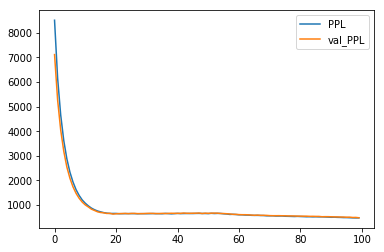

In [18]:
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [21]:
import os
if not os.path.exists(local_path + 'model/'):
    os.mkdir(local_path + 'model/')

path_model = local_path + 'model/model.keras'
model.save(path_model)

In [22]:
from tensorflow.python.keras.models import load_model

model_restore = load_model(path_model, custom_objects={'ACC':ACC,'PPL': PPL})

In [23]:
hist = model_restore.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=30,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/30
19/50 [==========>...................] - ETA: 13s - loss: 6.1350 - ACC: 0.1078 - PPL: 462.2678

KeyboardInterrupt: 

Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


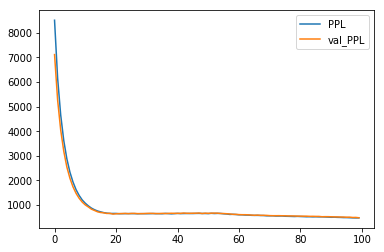

In [16]:
history = pd.DataFrame(hist.history)
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [0]:
X,Y = next(gen_word_word(batch_size=1, dataset='valid'))
X = list(X[0])
' '.join([id_to_word[id] for id in X])